In [1]:
import os
import pathlib
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# class MyModel(nn.Module):
#     def __init__(self, num_classes):
#         super(MyModel, self).__init__()

#         # Define the layers of the network
#         self.conv1 = nn.Conv2d(
#             in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1
#         )
#         self.relu1 = nn.ReLU(inplace=True)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv2 = nn.Conv2d(
#             in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1
#         )
#         self.relu2 = nn.ReLU(inplace=True)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv3 = nn.Conv2d(
#             in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1
#         )
#         self.relu3 = nn.ReLU(inplace=True)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv4 = nn.Conv2d(
#             in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1
#         )
#         self.relu4 = nn.ReLU(inplace=True)
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc4 = nn.Linear(in_features=256 * 16 * 16, out_features=512)
#         self.relu4 = nn.ReLU(inplace=True)

#         self.fc5 = nn.Linear(in_features=512, out_features=num_classes)

#     def forward(self, x):
#         # Pass the input through the layers of the network
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)

#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)

#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.pool3(x)

#         x = self.conv4(x)
#         x = self.relu4(x)
#         x = self.pool4(x)

#         x = x.view(x.size(0), -1)
#         x = self.fc4(x)
#         x = self.relu4(x)

#         x = self.fc5(x)

#         return x

In [3]:
# # Define the ResNet-based CNN model
# class ResNetCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNetCNN, self).__init__()
        
#         # Load the pre-trained ResNet-18 model
#         resnet = models.resnet152(pretrained=True)
        
#         # Remove the last fully connected layer
#         modules = list(resnet.children())[:-1]
#         self.resnet = nn.Sequential(*modules)
        
#         # Add a new fully connected layer
#         self.fc = nn.Linear(resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         # Pass the input through the ResNet model
#         x = self.resnet(x)
        
#         # Flatten the output tensor
#         x = x.view(x.size(0), -1)
        
#         # Pass the output through the fully connected layer
#         x = self.fc(x)
#         return x

In [4]:
for dirpath, dirnames, filenames in os.walk("Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

bean_class = len(os.listdir("data/train/"))

dataset_dir = pathlib.Path("data/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

There are 3 directories and 0 images in Dataset
There are 0 directories and 1000 images in Dataset\test
There are 36 directories and 0 images in Dataset\train
There are 0 directories and 22 images in Dataset\train\class_0
There are 0 directories and 24 images in Dataset\train\class_1
There are 0 directories and 24 images in Dataset\train\class_2
There are 0 directories and 24 images in Dataset\train\class_3
There are 0 directories and 24 images in Dataset\train\class_4
There are 0 directories and 24 images in Dataset\train\class_5
There are 0 directories and 24 images in Dataset\train\class_6
There are 0 directories and 24 images in Dataset\train\class_7
There are 0 directories and 24 images in Dataset\train\class_8
There are 0 directories and 24 images in Dataset\train\class_9
There are 0 directories and 24 images in Dataset\train\class_A
There are 0 directories and 24 images in Dataset\train\class_B
There are 0 directories and 24 images in Dataset\train\class_C
There are 0 directorie

In [5]:
# Define the hyperparameters and optimizer
num_epochs = 8
learning_rate = 0.001
batch_size = 64
num_classes = 35

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features

# Replace the last fully connected layer
model.fc = nn.Linear(num_features, num_classes)

# Move the model to the device
model = model.to(device)

d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# Data Transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229,0.224,0.225)),
    ]
)

In [9]:

# Define the dataset
train_set = datasets.ImageFolder(root='data/train', transform=transform)

# Define a data loader to iterate over the dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Define the dataset
val_set = datasets.ImageFolder(root='Dataset/val/', transform=transform)

# Define a data loader to iterate over the dataset
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Define the dataset
test_set = datasets.ImageFolder(root='data/test', transform=transform)

# Define a data loader to iterate over the dataset
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
train_predictions = np.array([])
train_ground_truths = np.array([])

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss / 100))
            running_loss = 0.0
    
    correct = 0
    total = 0

    # Calculate training accuracy
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    print('Training Accuracy: {:.2f}%'.format(train_acc * 100))

     # Validation
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            train_predictions = np.concatenate((train_predictions, predicted.cpu().numpy()))
            train_ground_truths = np.concatenate((train_ground_truths, labels.cpu().numpy()))

            val_loss += loss.item() * labels.size(0)
            _, predicted = device.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        
        # remove the extra predictions
        if len(train_predictions) > len(train_ground_truths):
            train_predictions = train_predictions[:len(train_ground_truths)]

    # Convert predictions and true labels to numpy arrays
    train_predictions = np.array(train_predictions)
    train_ground_truths = np.array(train_ground_truths)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    

d:\Salma\Coba\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Epoch 1, Batch   100] loss: 3.521


KeyboardInterrupt: 

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    ground_truths = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.numpy())
        ground_truths.extend(labels.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Validating Accuracy: {:.2f}%'.format(test_acc * 100))

Validating Accuracy: 99.54%


<Axes: >

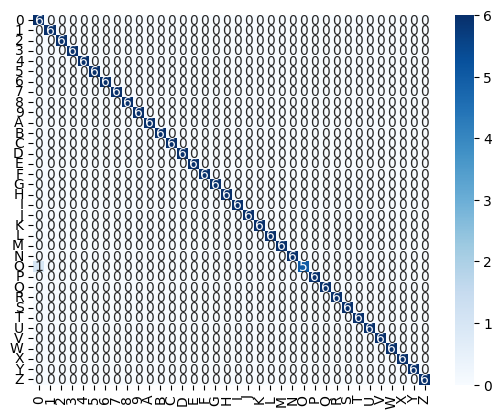

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(ground_truths, predictions)
labels_category = ['0', '1', '2', '3', '4', '5', '6','7', '8', '9', 'A', 'B', 'C', 'D','E', 'F', 'G', 'H', 'I', 'J', 'K','L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y', 'Z']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

In [ ]:
model = ResNetCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\wika/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|██████████| 230M/230M [01:18<00:00, 3.06MB/s] 


In [ ]:
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[Epoch %d, Batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Calculate training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print('Training Accuracy: {:.2f}%'.format(train_acc * 100))

d:\Salma\Coba\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 35.07%
Training Accuracy: 59.03%
Training Accuracy: 78.94%
Training Accuracy: 88.66%
Training Accuracy: 87.50%


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    ground_truths = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        predictions.extend(predicted.numpy())
        ground_truths.extend(labels.numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Testing Accuracy: {:.2f}%'.format(test_acc * 100))